# Andvaranaut tutorial

## Forward Module (Input distributions specified)

### Latin Hypercube Sampling
Import items form forward module as well as utils module

In [51]:
from andvaranaut.forward import *
from andvaranaut.utils import *

In [52]:
# Magic features for development purposes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


User supplies target function, which takes a 1D numpy array of nx inputs and returns a 1D numpy array of ny outputs. They must also supply a list of univariate distributions from scipy stats for each of the nx inputs.

In [53]:
# Example target function (2 inputs, 2 outputs)
# A more complex target function will produce an input file, 
# execute external code, and perform post-processing on output
def test_fun(x):
  x1,x2 = x
  return np.array([x1**2+x2,x1**3*x2**2])

# Input variable probability distributions
import scipy.stats as st
sample_space = [st.uniform(loc=0,scale=2),\
                st.norm(loc=1,scale=0.5)]

In [56]:
# Latin hypercube class instance, with correct arguments
l = LHC(nx=2,ny=2,priors=sample_space,target=test_fun,\
       parallel=False,nproc=1) # Last 2 args are optional & default

Sampling makes use of the latin_random function from py-design

In [57]:
# Sample input distributions by LHC and evaluate target function
l.sample(nsamps=4)
print(l.x)
print(l.y)

Evaluating 4 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.08 s
[[0.83272647 0.68615564]
 [0.13384195 1.12915785]
 [1.48168568 0.5646469 ]
 [1.69120189 1.99104487]]
[[1.37958902e+00 2.71864433e-01]
 [1.14707152e+00 3.05693427e-03]
 [2.76003935e+00 1.03710361e+00]
 [4.85120871e+00 1.91755780e+01]]


Parallel execution makes use of the ray package. This also works with SLURM submission if a SLURM script calls a python script with these commands in. (Tutorial will be added at a later date)

In [58]:
# Can also execute target function evaluation in parallel
l.parallel = True
l.nproc = 4
l.sample(nsamps=4)
ray.shutdown() # Shutdown ray parallelism, this command only good for interactive sessions
l.parallel = False
print(l.x)
print(l.y)

2021-05-13 16:08:30,958	INFO resource_spec.py:231 -- Starting Ray with 5.47 GiB memory available for workers and up to 2.75 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Evaluating 4 latin hypercube samples...


2021-05-13 16:08:31,506	INFO services.py:1193 -- View the Ray dashboard at localhost:8265


Run is 100.0% complete.
Time taken: 3.79 s
[[0.83272647 0.68615564]
 [0.13384195 1.12915785]
 [1.48168568 0.5646469 ]
 [1.69120189 1.99104487]
 [0.30194836 1.00635325]
 [1.34614257 0.57044871]
 [0.6181536  0.66432449]
 [1.80752128 1.38824419]]
[[1.37958902e+00 2.71864433e-01]
 [1.14707152e+00 3.05693427e-03]
 [2.76003935e+00 1.03710361e+00]
 [4.85120871e+00 1.91755780e+01]
 [4.65537736e+00 1.13810409e+01]
 [1.04643836e+00 1.04243679e-01]
 [2.38254853e+00 7.93791394e-01]
 [1.09752607e+00 2.78803968e-02]]


 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


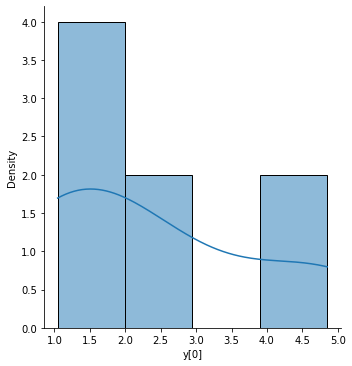

 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


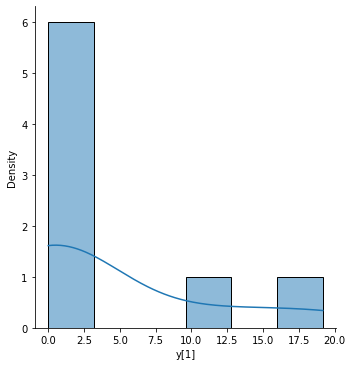

In [59]:
# Plot output distributions based on kernel density estimation
l.y_dist()

In [60]:
# Optionally delete n samples
# Default is deletion by closest sample to a coarse LHC of number of samples for deletion
l.del_samples(ndels=2,method='coarse_lhc')
print(l.x)
print(l.y,'\n')
# Can also delete by random indexing
l.del_samples(ndels=2,method='random')
print(l.x)
print(l.y,'\n')
# or by specific data indexes
l.del_samples(method='specific',idx=[0,1])
print(l.x)
print(l.y,'\n')

[[0.83272647 0.68615564]
 [0.13384195 1.12915785]
 [1.48168568 0.5646469 ]
 [1.69120189 1.99104487]
 [0.30194836 1.00635325]
 [1.34614257 0.57044871]]
[[1.37958902e+00 2.71864433e-01]
 [1.14707152e+00 3.05693427e-03]
 [2.76003935e+00 1.03710361e+00]
 [4.85120871e+00 1.91755780e+01]
 [4.65537736e+00 1.13810409e+01]
 [1.04643836e+00 1.04243679e-01]] 

[[1.69120189 1.99104487]
 [1.48168568 0.5646469 ]
 [0.30194836 1.00635325]
 [0.13384195 1.12915785]]
[[4.85120871e+00 1.91755780e+01]
 [2.76003935e+00 1.03710361e+00]
 [4.65537736e+00 1.13810409e+01]
 [1.14707152e+00 3.05693427e-03]] 

[[0.30194836 1.00635325]
 [0.13384195 1.12915785]]
[[4.65537736e+00 1.13810409e+01]
 [1.14707152e+00 3.05693427e-03]] 



If datasets exist then it is possible to set the class attributes directly with these. They must be in the form of 2d numpy float arrays. An additional consideration is the provided x data must be compatible with the existing distributions. WARNING: This will likely invalidate relationship of samples to selected input distributions and therefore invalidate output distributions.

In [9]:
x = np.random.rand(5,2)
y = np.random.rand(5,2)
l.set_data(x=x,y=y)
print(l.x)
print(l.y)

[[0.48293971 0.65486071]
 [0.64920979 0.83549232]
 [0.07144143 0.80526126]
 [0.56080791 0.08897495]
 [0.41338521 0.5458857 ]]
[[0.37865254 0.19782173]
 [0.46708551 0.36089304]
 [0.55946708 0.40680703]
 [0.01896823 0.23765641]
 [0.46072749 0.42665491]]


### Gaussian process surrogate

In addition to the arguments provided to the lhc class, there are additional arguments for a list of classes which handle conversion and reversion of the x and y datasets, respectively. These are necessary for optimising surrogate performance, and usually consist of transforming bounded ranges on inputs and outputs to unbounded. Normalisations to get numbers O(1) are also useful and can be implemented either here or within the target function.

These conversion/reversion arguments are optional, and can be left blank if desired. Standard methods are provided in andvaranaut.utils, with the logarithm and uniform classes shown below for clarity on the format. A user can define their own class in this format, as long as any additional arguments like the distribution object in uniform are packaged into partial functions within the class.

In [10]:
# Convert positive values to unbounded with logarithm
def log_con(y):
  return np.log10(y)
# Revert logarithm with power
def log_rev(y):
  return np.power(10,y)
class logarithm:
  def __init__(self):
    self.con = log_con # Conversion function
    self.rev = log_rev # Reversion function

from functools import partial
# Convert uniform dist samples into standard uniform 
def std_uniform(x,dist):
  intv = dist.interval(1.0)
  x = (x-intv[0])/(intv[1]-intv[0])
  return x
# Revert to original uniform distributions
def uniform_rev(x,dist):
  intv = dist.interval(1.0)
  x = x*(intv[1]-intv[0])+intv[0]
  return x
class uniform:
  def __init__(self,dist):
    self.con = partial(std_uniform,dist=dist)
    self.rev = partial(uniform_rev,dist=dist)

In [63]:
# Define lists of conversion/reversion class instances for each x and y variable
xconrevs = [uniform(sample_space[0]),normal(sample_space[1])]
yconrevs = [None,logarithm()]
# Instance of gp, only nx, ny, dists, and target are req
g = GP(kernel='RBF',noise=False,xconrevs=xconrevs,yconrevs=yconrevs,\
       nx=2,ny=2,priors=sample_space,target=test_fun,parallel=False,nproc=4)

Methods from lhc class are inherited by the GP class with some additions like automatic conversion of new samples

In [64]:
g.sample(2)
print(g.x)
print(g.y)
print(g.xc)
print(g.yc)

Evaluating 2 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.04 s
[[0.75022107 1.65261825]
 [1.96559815 0.37353619]]
[[2.21544991 1.15322187]
 [4.2371123  1.05961862]]
[[ 0.37511054  1.30523651]
 [ 0.98279908 -1.25292762]]
[[2.21544991 0.14255965]
 [4.2371123  0.05790905]]


Can change conversion/reversion classes without reinitialising class

In [65]:
xconrevs = [logit_logistic(sample_space[0]),None]
yconrevs = [None,nonneg()]
g.change_conrevs(xconrevs,yconrevs)
print(g.x)
print(g.y)
print(g.xc)
print(g.yc)

[[0.75022107 1.65261825]
 [1.96559815 0.37353619]]
[[2.21544991 1.15322187]
 [4.2371123  1.05961862]]
[[-0.51035403  1.65261825]
 [ 4.04544168  0.37353619]]
[[2.21544991 0.14255965]
 [4.2371123  0.05790905]]


Take some more samples and fit GP surrogate to converted data

In [66]:
g.sample(nsamps=98)

Evaluating 98 latin hypercube samples...
Run is 100.0% complete.
Time taken: 1.36 s


In [67]:
g.fit(restarts=3)

Optimizing hyperparameters...
Optimization restart 1/3, f = -487.7047774497428
Optimization restart 2/3, f = -487.7047692809025
Optimization restart 3/3, f = -487.70477639072465
Time taken: 0.43 s


Your fitted model will be a GPy GPRegression object and as such will retain all GPy functionality. It can be accessed as the 'm' attribute of the gp class.

In [68]:
print(g.m[''])

  index  |             GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |                             2.95899226  |      +ve      |        
  -----  |          GP_regression.rbf.lengthscale  |  -----------  |  ------
  [0]    |                             2.27142600  |      +ve      |        
  [1]    |                             0.28705528  |      +ve      |        
  -----  |  GP_regression.Gaussian_noise.variance  |  -----------  |  ------
  [0]    |                             0.00000000  |   +ve fixed   |        


Make a train-test set and produce plots to assess GP performance

In [69]:
g.train_test(training_frac=0.9)

 /usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


Optimizing hyperparameters...
Optimization restart 1/1, f = -377.3177930304406
Time taken: 0.07 s
Predicting...
Time taken: 0.00 s

RMSE for y[0] is: 0.0035751044701131415
RMSE for y[1] is: 0.005634400925498861


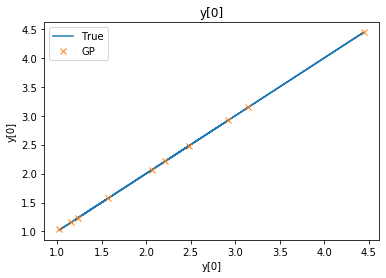

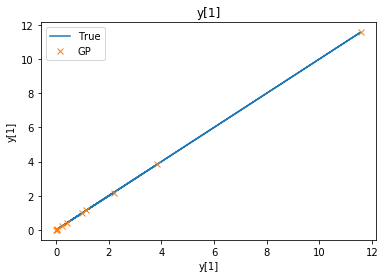

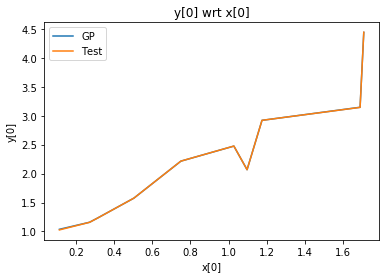

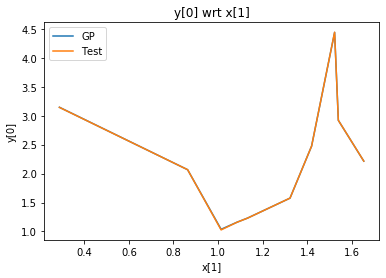

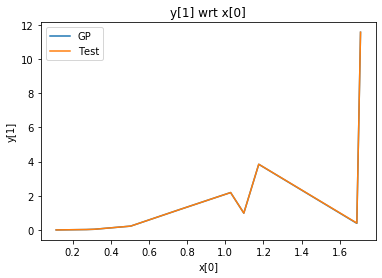

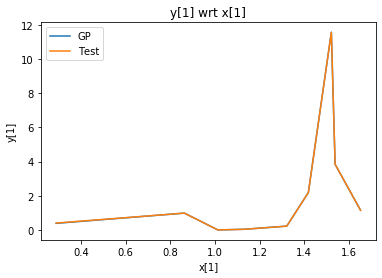

In [70]:
g.test_plots(revert=True,restarts=1,yplots=True,xplots=True)

Can change model details (kernel choice and whether data contains noise) without reinitialsing class. This will scrub any fitted model and require a new call to gp.fit().

Optimizing hyperparameters...
Optimization restart 1/10, f = -104.72618370798968
Optimization restart 2/10, f = -104.72618370476545
Optimization restart 3/10, f = -104.7261837067679
Optimization restart 4/10, f = -104.72618370831817
Optimization restart 5/10, f = -104.72618368736869
Optimization restart 6/10, f = -104.72618370597944
Optimization restart 7/10, f = -104.72618370843782
Optimization restart 8/10, f = -104.72618370280077
Optimization restart 9/10, f = -104.72618368942213
Optimization restart 10/10, f = -104.72618370783056
Time taken: 0.88 s
Optimizing hyperparameters...
Optimization restart 1/10, f = -83.42448561749372
Optimization restart 2/10, f = -83.42448561082745
Optimization restart 3/10, f = -83.42448561790056
Optimization restart 4/10, f = -83.42448561747483
Optimization restart 5/10, f = -83.42448561802625
Optimization restart 6/10, f = -83.42448561719499
Optimization restart 7/10, f = -83.42448535740219
Optimization restart 8/10, f = -83.42448561732236
Optimizatio

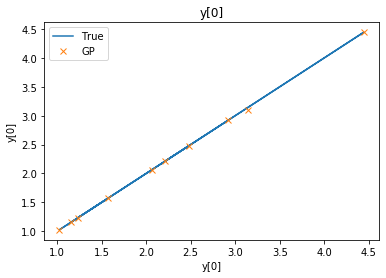

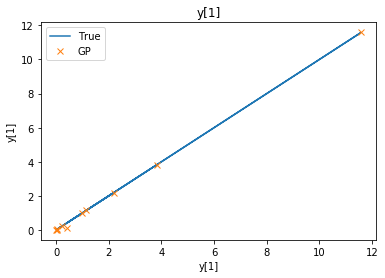

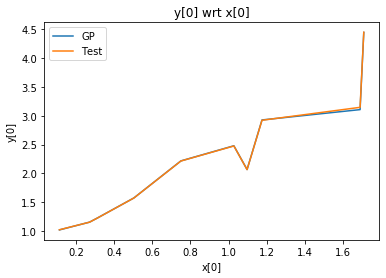

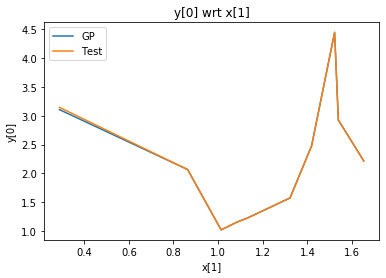

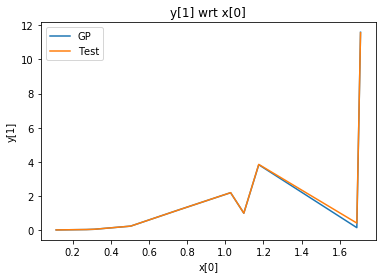

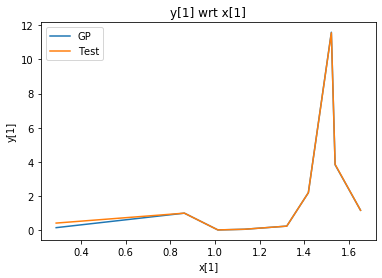

In [71]:
g.change_model(kernel='Exponential',noise=True)
g.fit()
g.test_plots()

Propagate uncertainty using surrogate and get target distributions

Optimizing hyperparameters...
Optimization restart 1/10, f = -104.72618370843068
Optimization restart 2/10, f = -104.72618370843324
Optimization restart 3/10, f = -104.72618369326005
Optimization restart 4/10, f = -104.72618370772294
Optimization restart 5/10, f = -104.72618370724973
Optimization restart 6/10, f = -104.72618370677617
Optimization restart 7/10, f = -104.7261837083878
Optimization restart 8/10, f = -104.72618370843132
Optimization restart 9/10, f = -104.72618364961289
Optimization restart 10/10, f = -104.72618370844744
Time taken: 0.89 s
Predicting...
Time taken: 0.06 s


 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


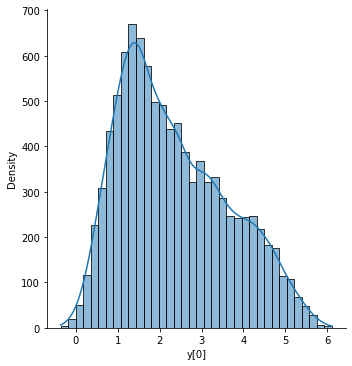

 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


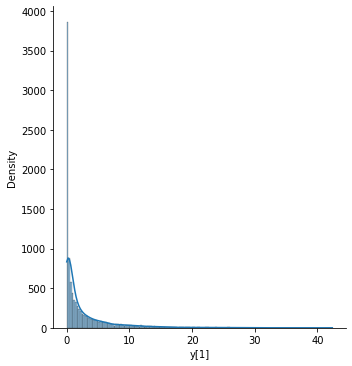

In [73]:
g.change_model(kernel='Exponential',noise=False)
g.fit()
x,y = g.y_dist(mode='hist_kde',nsamps=10000,return_data=True,surrogate=True)

Plot also the distrutions based on underyling 100 LHC samples

 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


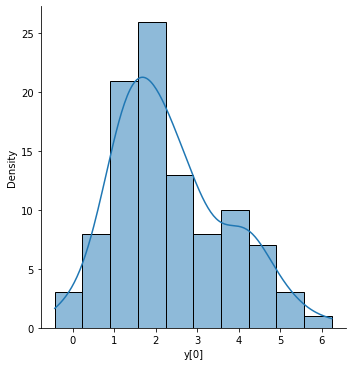

 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


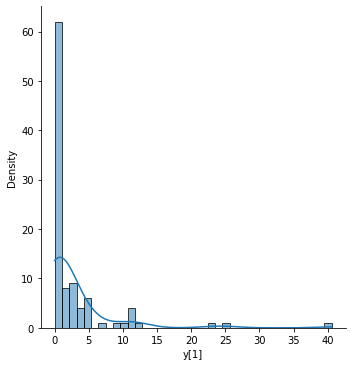

In [74]:
g.y_dist(surrogate=False)

Get 1000 actual function evaluations for comparison with GP surrogate plots. GP based on 100 evaluations gives good qualitative agreement.

In [79]:
l = LHC(nx=2,ny=2,priors=sample_space,target=test_fun)

In [80]:
l.sample(1000)

Evaluating 1000 latin hypercube samples...
Run is 100.0% complete.
Time taken: 13.00 s


 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


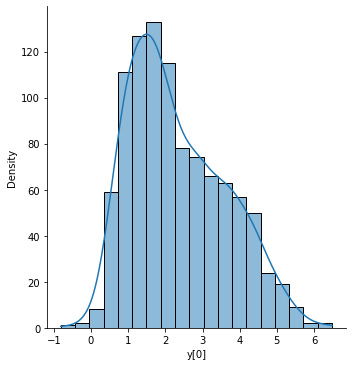

 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/u1997128/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


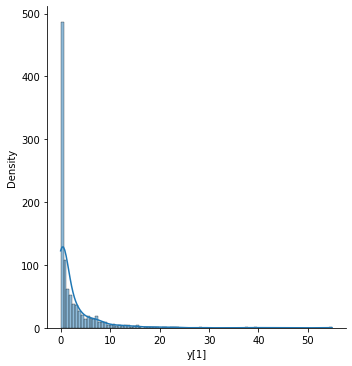

In [81]:
l.y_dist()

The lengthscales of the fitted GP give an insight into sensitivities of the outputs to the inputs. Relative log importances can be plotted either using converted or original datasets.

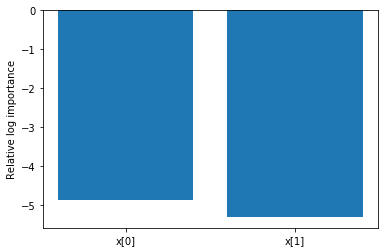

Optimizing hyperparameters...
Optimization restart 1/10, f = -56.028773549480576
Optimization restart 2/10, f = -56.028773591486
Optimization restart 3/10, f = -56.028773592010396
Optimization restart 4/10, f = -56.0287735834646
Optimization restart 5/10, f = -56.02877353071301
Optimization restart 6/10, f = -56.02877359212896
Optimization restart 7/10, f = -56.028773592257906
Optimization restart 8/10, f = -56.0287735913284
Optimization restart 9/10, f = -56.02877359023982
Optimization restart 10/10, f = -56.028773590095284
Time taken: 0.76 s


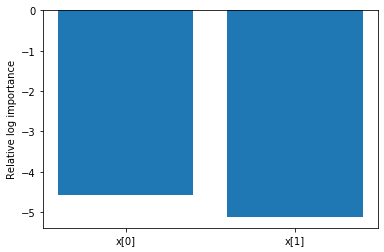

In [82]:
g.relative_importances()
g.relative_importances(original_data=True,restarts=10)

In addition to LHC samples, there is also the option of utilising adaptive sampling. This aims to add samples at points which best balance improved accuracy and input parameter space exploration. Method based on Mohammadi, Hossein, et al. "Cross-validation based adaptive sampling for Gaussian process models." arXiv preprint arXiv:2005.01814 (2020).

Evaluating 50 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.68 s
Optimizing hyperparameters...
Optimization restart 1/10, f = -183.86488640729686
Optimization restart 2/10, f = -183.86488639571724
Optimization restart 3/10, f = -183.86488609514885
Optimization restart 4/10, f = -183.86488651459365
Optimization restart 5/10, f = -183.86488617626077
Optimization restart 6/10, f = -183.86488656406524
Optimization restart 7/10, f = -183.8648863428295
Optimization restart 8/10, f = -183.8648862985138
Optimization restart 9/10, f = -183.86488637850778
Optimization restart 10/10, f = -183.86488632461385
Time taken: 0.66 s
Calculating ESE_loo...
Time taken: 0.59 s
Fitting auxillary GP to ESE_loo data...
Optimizing hyperparameters...
Optimization restart 1/10, f = 169.58238426209175
Optimization restart 2/10, f = 169.582392728593
Optimization restart 3/10, f = 169.58238516998995
Optimization restart 4/10, f = 169.58238356346857
Optimization restart 5/10, f = 169.5823994818631

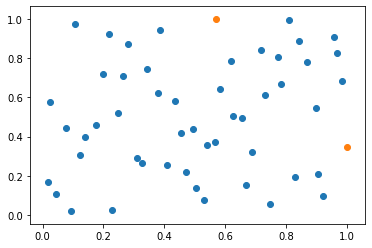

Evaluating function at sample points
Run is 100.0% complete.
Time taken: 0.04 s
Optimizing hyperparameters...
Optimization restart 1/10, f = -176.7631445959133
Optimization restart 2/10, f = -176.76314453598346
Optimization restart 3/10, f = -176.76314428524623
Optimization restart 4/10, f = -176.76314440576456
Optimization restart 5/10, f = -176.76314458997214
Optimization restart 6/10, f = -176.76314467178676
Optimization restart 7/10, f = -176.76314437092614
Optimization restart 8/10, f = -176.76314448892876
Optimization restart 9/10, f = -176.76314474225725
Optimization restart 10/10, f = -176.7631446539244
Time taken: 0.57 s
Calculating ESE_loo...
Time taken: 0.58 s
Fitting auxillary GP to ESE_loo data...
Optimizing hyperparameters...
Optimization restart 1/10, f = 169.19771479656507
Optimization restart 2/10, f = 169.19773082560187
Optimization restart 3/10, f = 169.19771369563094
Optimization restart 4/10, f = 169.19771435109578
Optimization restart 5/10, f = 169.1977137676131
O

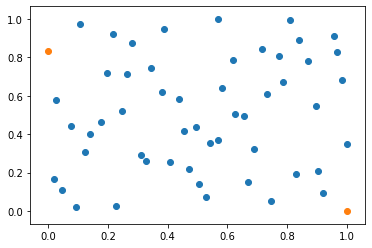

Evaluating function at sample points
Run is 100.0% complete.
Time taken: 0.03 s
Optimizing hyperparameters...
Optimization restart 1/10, f = -201.5160029713055
Optimization restart 2/10, f = -201.51600327830386
Optimization restart 3/10, f = -201.51600228954374
Optimization restart 4/10, f = -201.51600340338
Optimization restart 5/10, f = -201.51600362609645
Optimization restart 6/10, f = -201.5160028947925
Optimization restart 7/10, f = -201.51600315840733
Optimization restart 8/10, f = -201.51600306021663
Optimization restart 9/10, f = -201.51600327533035
Optimization restart 10/10, f = -201.51600350196153
Time taken: 0.61 s
Calculating ESE_loo...
Time taken: 0.62 s
Fitting auxillary GP to ESE_loo data...
Optimizing hyperparameters...
Optimization restart 1/10, f = 174.70419767089493
Optimization restart 2/10, f = 174.70419681750602
Optimization restart 3/10, f = 174.70419810293515
Optimization restart 4/10, f = 174.70419722048084
Optimization restart 5/10, f = 174.7041970773245
Opti

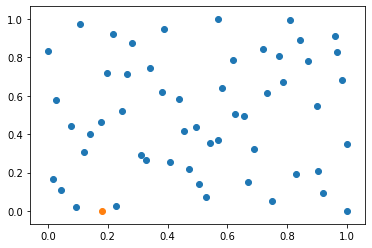

Evaluating function at sample points
Run is 100.0% complete.
Time taken: 0.05 s


In [88]:
g = GP(kernel='RBF',noise=False,xconrevs=xconrevs,yconrevs=yconrevs,\
       nx=2,ny=2,priors=sample_space,target=test_fun,parallel=False,nproc=4)
g.sample(50)
g.sample(nsamps=5,batchsize=2,method='adaptive')

## Inverse module

### Maximum a posteriori (MAP)

## Utils module

### Save and load objects

In [89]:
# Save lhc class including datasets
l = LHC(nx=2,ny=2,priors=sample_space,target=test_fun)
l.sample(2)
save_object(obj=l,fname='lhc_tut.pickle')

Evaluating 2 latin hypercube samples...
Run is 100.0% complete.
Time taken: 0.04 s


PicklingError: Can't pickle <class 'andvaranaut.forward.LHC'>: it's not the same object as andvaranaut.forward.LHC

In [ ]:
# Load lhc class
l = load_object(fname='lhc_tut.pickle')
print(l.x)
print(l.y)

### Standard conversion/reversion classes

Some examples were shown previously in the tutorial but the full list will be given here for completeness:

normal - requires dist argument upon initialisation and converts samples from any normal distribution to a standard normal sample. 
  
uniform - as above but any uniform distribution to standard uniform.  
  
logit-logistic - requires dist argument and converts any uniform distribution sample to an unbounded range via logit  
  
probit - as above but converts to standard normal sample via distribution cdf's  
  
nonneg - converts any non-negative values to unbounded values by the transformation y' = y/(1+y) which has a range [0,1] and then taking the logit.  
  
logarithm - takes a log with base ten to transform any positive values to unbounded  

normalise - requires a fac argument and applies a y/fac conversion